In [1]:
method_name = 'Idealised'
catchment_name = 'LinDyke'

In [9]:
# import os
# from pathlib import Path
# from PIL import Image
# # import geopandas as gpd
# import itertools
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats
# import seaborn as sns
# from branca.element import Template, MacroElement
from matplotlib import cm
# import earthpy.spatial as es
from rasterio import plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from my_functions import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define whether to filter out values <0.1
remove_little_values = True

In [35]:
ld_dict = {'name':'LinDyke',
              'name_str':'Resampled.Terrain',
           'shpfile_name':'CatchmentLinDyke_exported',
              "centre_location" : [53.768306874761016, -1.3756056884868098]
    }
wb_dict = {'name':'WykeBeck',
          'name_str':'Terrain.wykeDEM',
           'shpfile_name':'WykeBeckCatchment',
          "centre_location" : [53.81001289603593, -1.483594591196338]}

In [412]:
def plot_spatial(axs,fp, catchment_gdf,  cbar=True, colors=None, labels=None,legend=True):
    
    #################################################################
    # Read in and prepare data
    #################################################################
    # Read in shapefile for use in cropping
    with rasterio.open(fp) as raster_crs:
        # Get crs to read in the catchment shape file
        crop_raster_profile = raster_crs.profile
        crop_bound_utm13N = catchment_gdf.to_crs(crop_raster_profile["crs"])    
    
    # Read in raster data amd crop to the shapefile
    with rasterio.open(fp) as src:
        single_cropped_image, single_cropped_meta = es.crop_image(
        src, crop_bound_utm13N)
    
    # Create the extent object for plotting
    single_crop_extent = plotting_extent(single_cropped_image[0], single_cropped_meta["transform"])
    
    #################################################################
    # Set up colors for plotting
    #################################################################
    # For landcover plot (where colours list is specified)
    if colors!=None:
        # Create the colourmap
        cmap = mpl.colors.ListedColormap(colors)
        # And set up the legend object
        if legend == True:
            patches_list = []
            for i, color in  enumerate(colors):
                patch =  mpatches.Patch(color=color, label=labels[i])
                patches_list.append(patch)  
            axs.legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =5);
    
    # For terrain plot
    else:
        cmap = 'RdBu_r'
    
    #################################################################
    # Mask array if necessary (in this case this is for the terrain data)
    #################################################################
    # For landcover plot
    if colors != None:
        # Mask array (don't want to include values of 0, as these are no data values here)
        single_cropped_image = np.ma.masked_array(single_cropped_image[0], single_cropped_image[0] < 0.001)
        # Define a vmin and vmax (so it uses the values for this plot)
        vmin = np.nanmin(single_cropped_image)
        vmax = np.nanmax(single_cropped_image)
    
    # For terrain plot
    # Define a vmin and vmax (so it's consistent across the plots)
    else:
        vmin = -0.05
        vmax = 0.05
#         vmin = np.nanmin(single_cropped_image)
#         vmax = np.nanmax(single_cropped_image)
    
    #################################################################
    # Plot the image
    #################################################################
    crop_bound_utm13N.boundary.plot(ax=axs, color="black", zorder=10)
    ep.plot_bands(single_cropped_image, ax=axs, extent=single_crop_extent, cmap = cmap, 
                      vmin=vmin,vmax=vmax,cbar=cbar)
        
    # Add the watercourse track
    watercourses_clip.plot(ax=axs, linewidth=3, color = 'black')    
    axs.axis('off')

In [81]:
# find_difference_between_extremes(wb_dict, 'Depth', 'Idealised')
find_difference_between_extremes(wb_dict, 'Depth', 'Observed')

../../../FloodModelling/WykeBeckModels/Model_ObservedProfiles/CalculatedLayers/DifferencesBetweenExtremes_Depth_Observed.tif


In [74]:
import earthpy.spatial as es
from rasterio.plot import plotting_extent
import earthpy.plot as ep

watercourses = gpd.read_file('../../../FloodModelling/ExtraData/Watercourses/WatercourseLink.shp')
watercourses_clip = gpd.clip(watercourses, catchment_gdf)

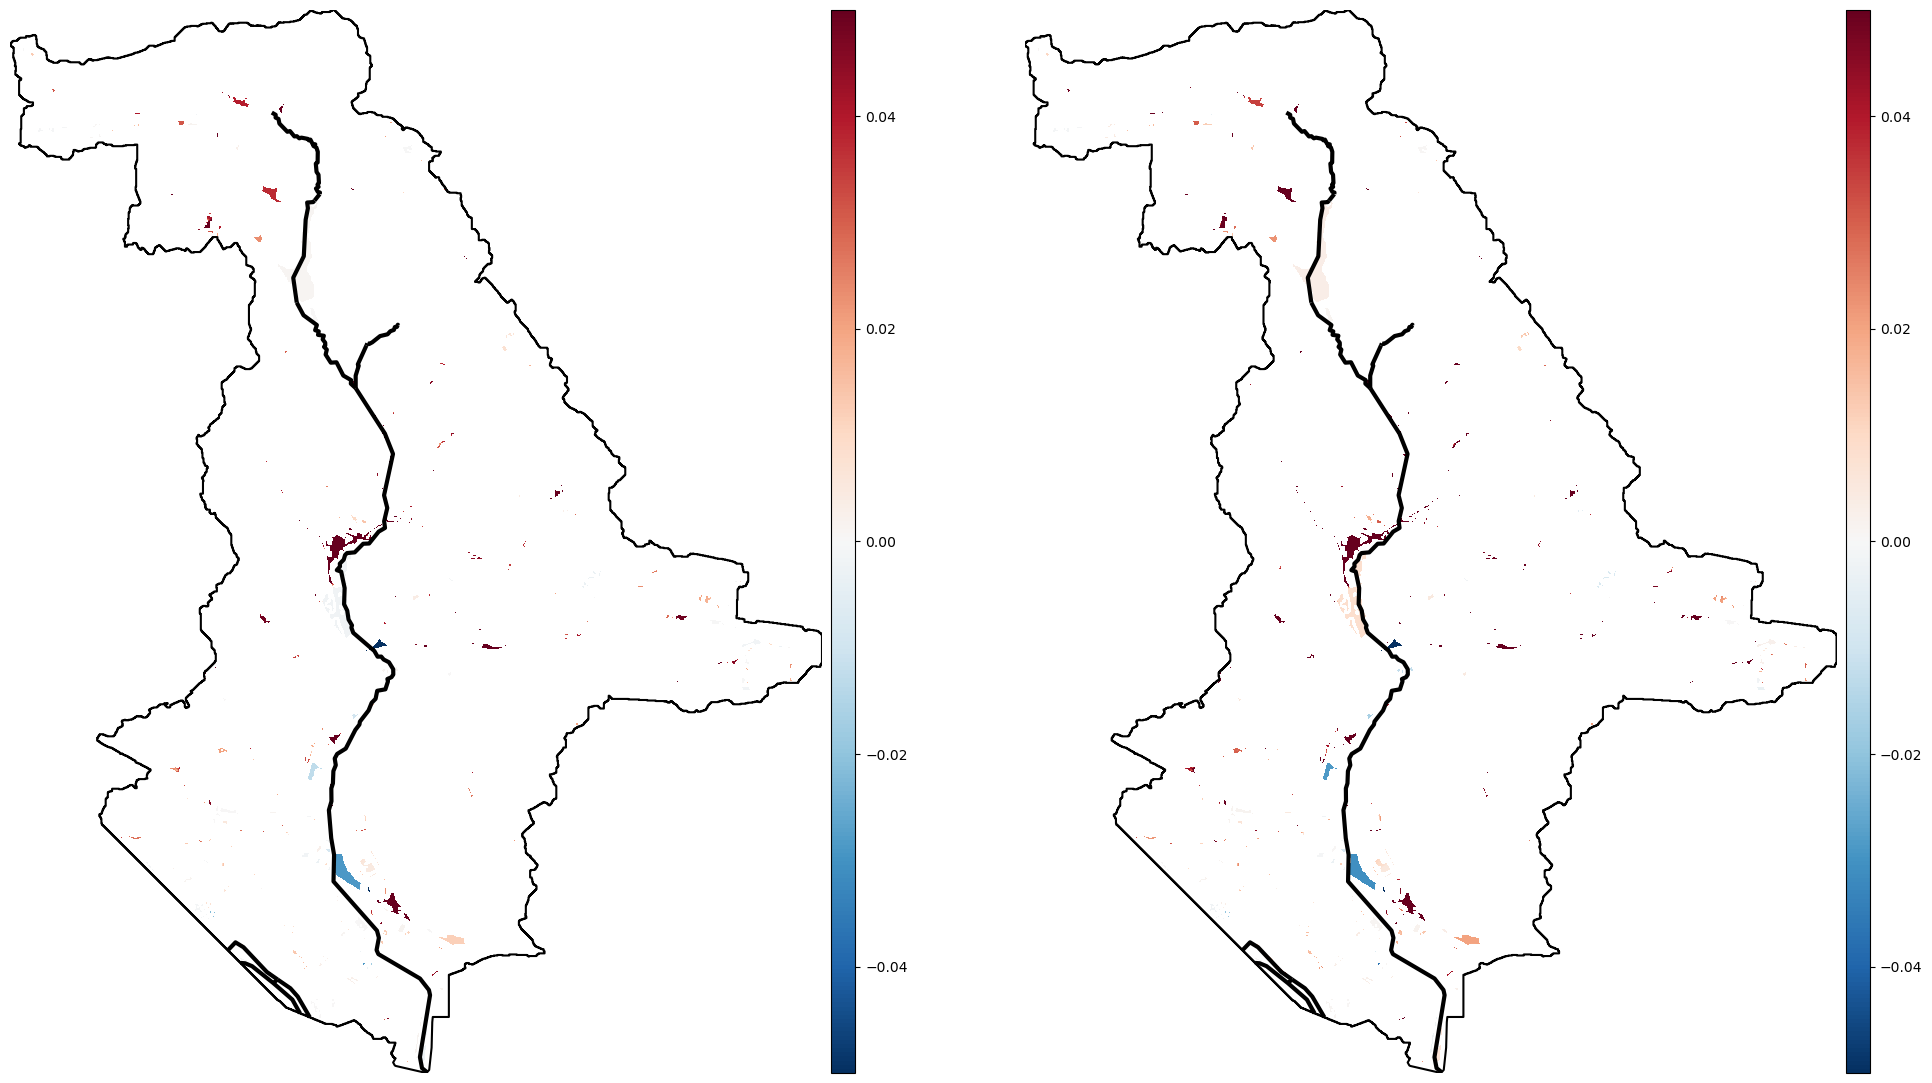

In [413]:
fig, axs = plt.subplots(ncols=2, figsize=(24, 40))
catchment_dict=wb_dict
model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
catchment_gdf = gpd.read_file(catchment_shp)

plot_spatial(axs[0], model_directory + f"CalculatedLayers/DifferencesBetweenExtremes_{'Depth'}_{'Idealised'}.tif", 
            catchment_gdf)
model_directory = f"../../../FloodModelling/{catchment_dict['name']}Models/Model_{'Observed'}Profiles/"
plot_spatial(axs[1], model_directory + f"CalculatedLayers/DifferencesBetweenExtremes_{'Depth'}_{'Observed'}.tif", 
            catchment_gdf)

In [165]:
cmap = mpl.cm.RdYlGn.copy()
cmap.set_bad('w', 1.)

In [444]:
def find_difference_between_extremes(catchment_dict, variable_name, method_name):
    
    # Find the catchment shapefile
    model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
    catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
    catchment_gdf = gpd.read_file(catchment_shp)

    # Get string relating to most/least extreme scenarios
    if method_name == 'Idealised':
        most_extreme_str,least_extreme_str = '6h_sp_bl_0.9',"6h_sp_fl_0.1"
    elif method_name == 'Observed':
        most_extreme_str,least_extreme_str = '6h_c5',"6h_c8"        
    elif method_name == 'SinglePeak_Scaled':
        most_extreme_str,least_extreme_str = '6h_sp_+0%', "6h_sp_+20%"        
    
    # Read in data
    most_extreme = prep_for_folium_plotting(model_directory+ f"{most_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif")
    least_extreme = prep_for_folium_plotting(model_directory+ f"{least_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif")
    
    #most_extreme.data[np.isnan(most_extreme.data.data)] = 0
    #least_extreme.data[np.isnan(least_extreme.data)] = 0
    
    # 
    #most_extreme.data[~np.isnan(least_extreme.data)] = 0
    #least_extreme.data[~np.isnan(most_extreme.data)] = 0
    
    
    # most_extreme.data[np.isnan(most_extreme.data) and (~np.isnan(least_extreme.data))] = 0
    #most_extreme.data[(~np.isnan(least_extreme.data) & np.isnan(most_extreme.data)).all()] = 0
    #least_extreme.data[(~np.isnan(most_extreme.data) & np.isnan(least_extreme.data)).all()] = 0
    
    
    most_extreme.data[np.isnan(most_extreme.data) & (~np.isnan(least_extreme.data))] = 0
    least_extreme.data[np.isnan(least_extreme.data) & (~np.isnan(most_extreme.data))] = 0
    
    # Find the difference and save
    diff= most_extreme -least_extreme
    
    # Where they have the same value, filter out
    #diff.data[diff.data ==0.0] = np.nan
    
    out_meta = rasterio.open(model_directory+ f"{most_extreme_str}/Depth (Max).{catchment_dict['name_str']}.tif").meta.copy()
    save_array_as_raster(diff, model_directory + f"CalculatedLayers/DifferencesBetweenExtremes_{variable_name}_{method_name}.tif", out_meta) 

    # Find difference as either a positive or a negative
    pos_neg_depth_diff = np.where((np.isnan(diff)), np.nan, 
                          np.where((diff < 0), 0,
                            np.where((diff == 0), 1,
                                np.where((diff > 0), 2, 500))))
    save_array_as_raster(pos_neg_depth_diff, 
                         model_directory + f"CalculatedLayers/PosNegDifferencesBetweenExtremes_{variable_name}_{method_name}.tif", out_meta) 
    
    
def plot_difference_between_extremes(catchment_dict, variable_name, method_name, ax,add_basemap= True, add_colorbar= False):
    #######################################
    # Read in catchment shapefile
    #######################################
    model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
    catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
    catchment_gdf = gpd.read_file(catchment_shp)
    
    #######################################
    # Define colormap
    #######################################
    cmap = mpl.cm.RdYlGn.copy()
    cmap.set_bad('purple', 1.)
    
    #######################################
    # Plot catchment boundary and basemap
    #######################################
    catchment_gdf.plot(ax=ax, facecolor="none", linewidth=5, edgecolor = 'black')
    if add_basemap == True:
        cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
    
    #######################################
    # Read in data and add to map
    #######################################
    fp = model_directory + f"CalculatedLayers/DifferencesBetweenExtremes_{variable_name}_{method_name}.tif"
    array = rasterio.open(fp)
    image = plot.show(array, ax=ax,  cmap='RdBu_r',  vmin=-0.5,  vmax=0.05)
    
    #######################################
    # Format
    #######################################
    ax.axis('off')
    ax.set_title(method_name, fontsize =20)
    
    # Colorbar creation
    if add_colorbar == True:  
        if add_basemap == True:
            im = image.get_images()[1]
        else:
            im = image.get_images()[0]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="8%", pad=0.09)
        fig.colorbar(im, cax)

In [402]:
find_difference_between_extremes(wb_dict, 'Depth', 'Idealised')
find_difference_between_extremes(wb_dict, 'Depth', 'Observed')

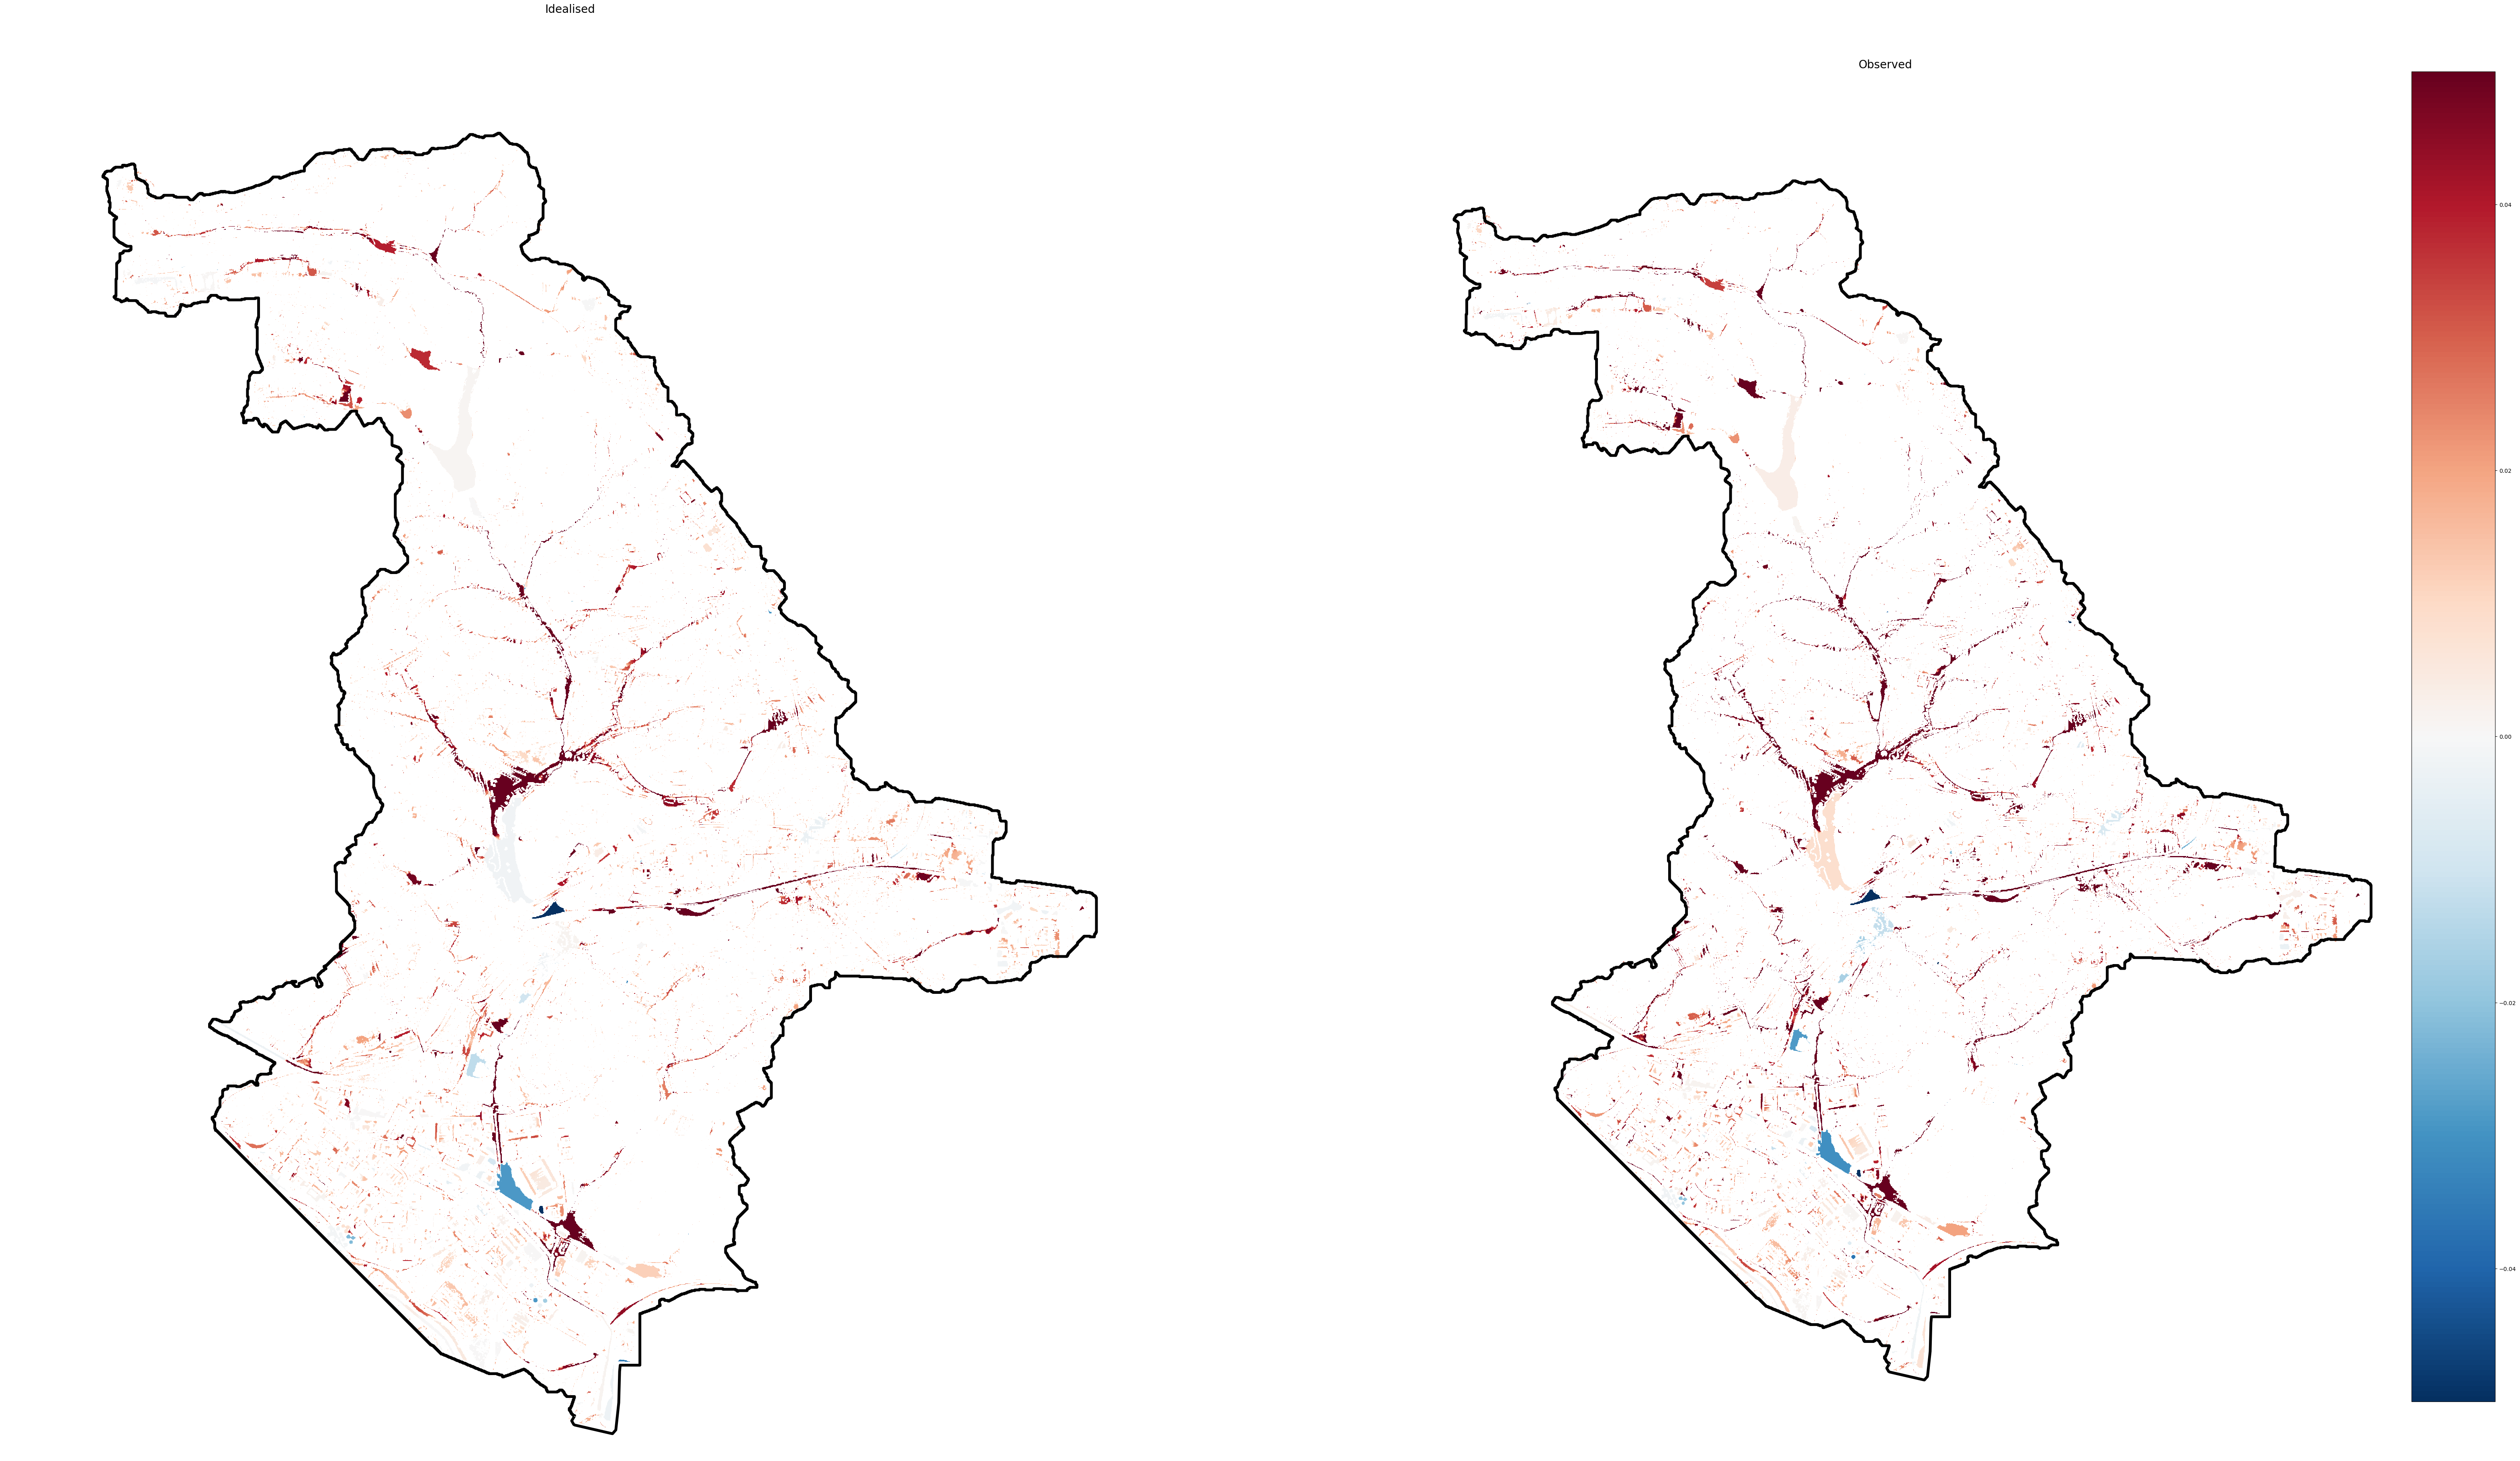

In [454]:
fig, axs = plt.subplots(ncols=2, figsize=(80, 160))
plot_difference_between_extremes(wb_dict, 'Depth', 'Idealised', axs[0], False)
plot_difference_between_extremes(wb_dict, 'Depth', 'Observed', axs[1], False, True)
# fig.savefig("test.jpg",dpi=2000)
# fig.savefig('myimage.jpg', format='jpg', dpi=1200)

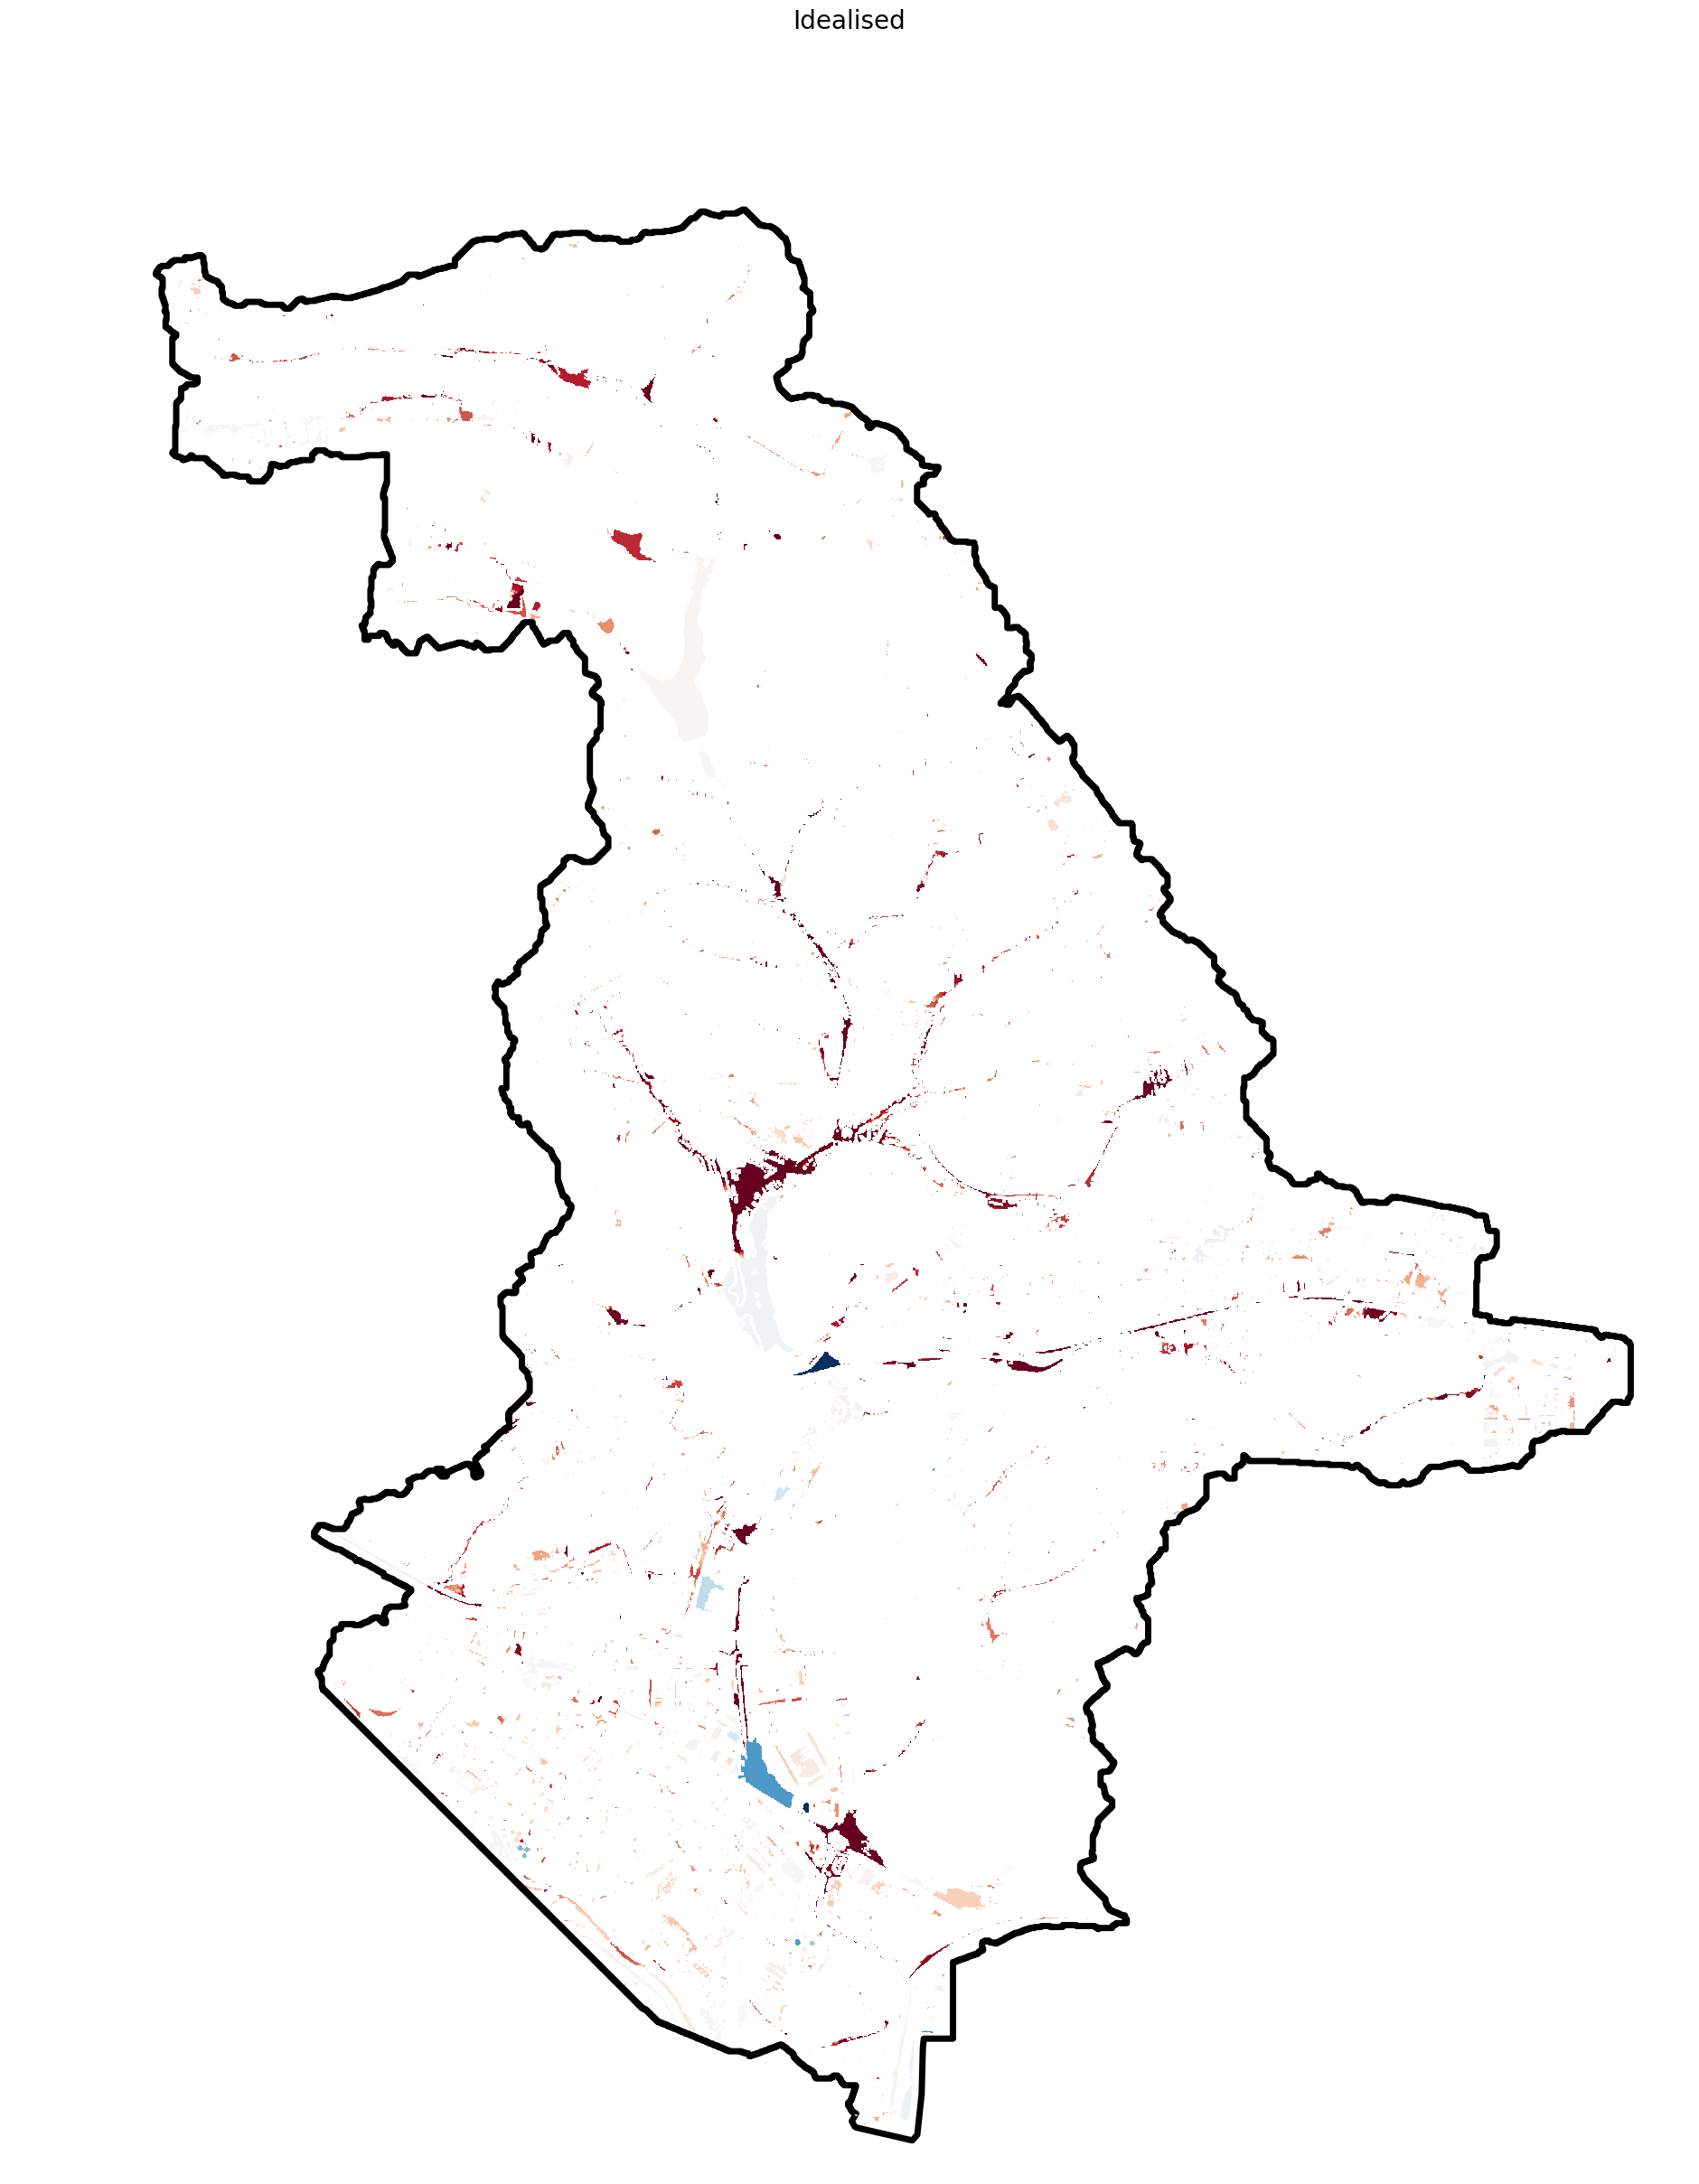

In [446]:
fig, axs = plt.subplots(ncols=1, figsize=(24, 40))
plot_difference_between_extremes(wb_dict, 'Depth', 'Idealised', axs, False)
# plot_difference_between_extremes(wb_dict, 'Depth', 'Observed', axs[1], False, True)

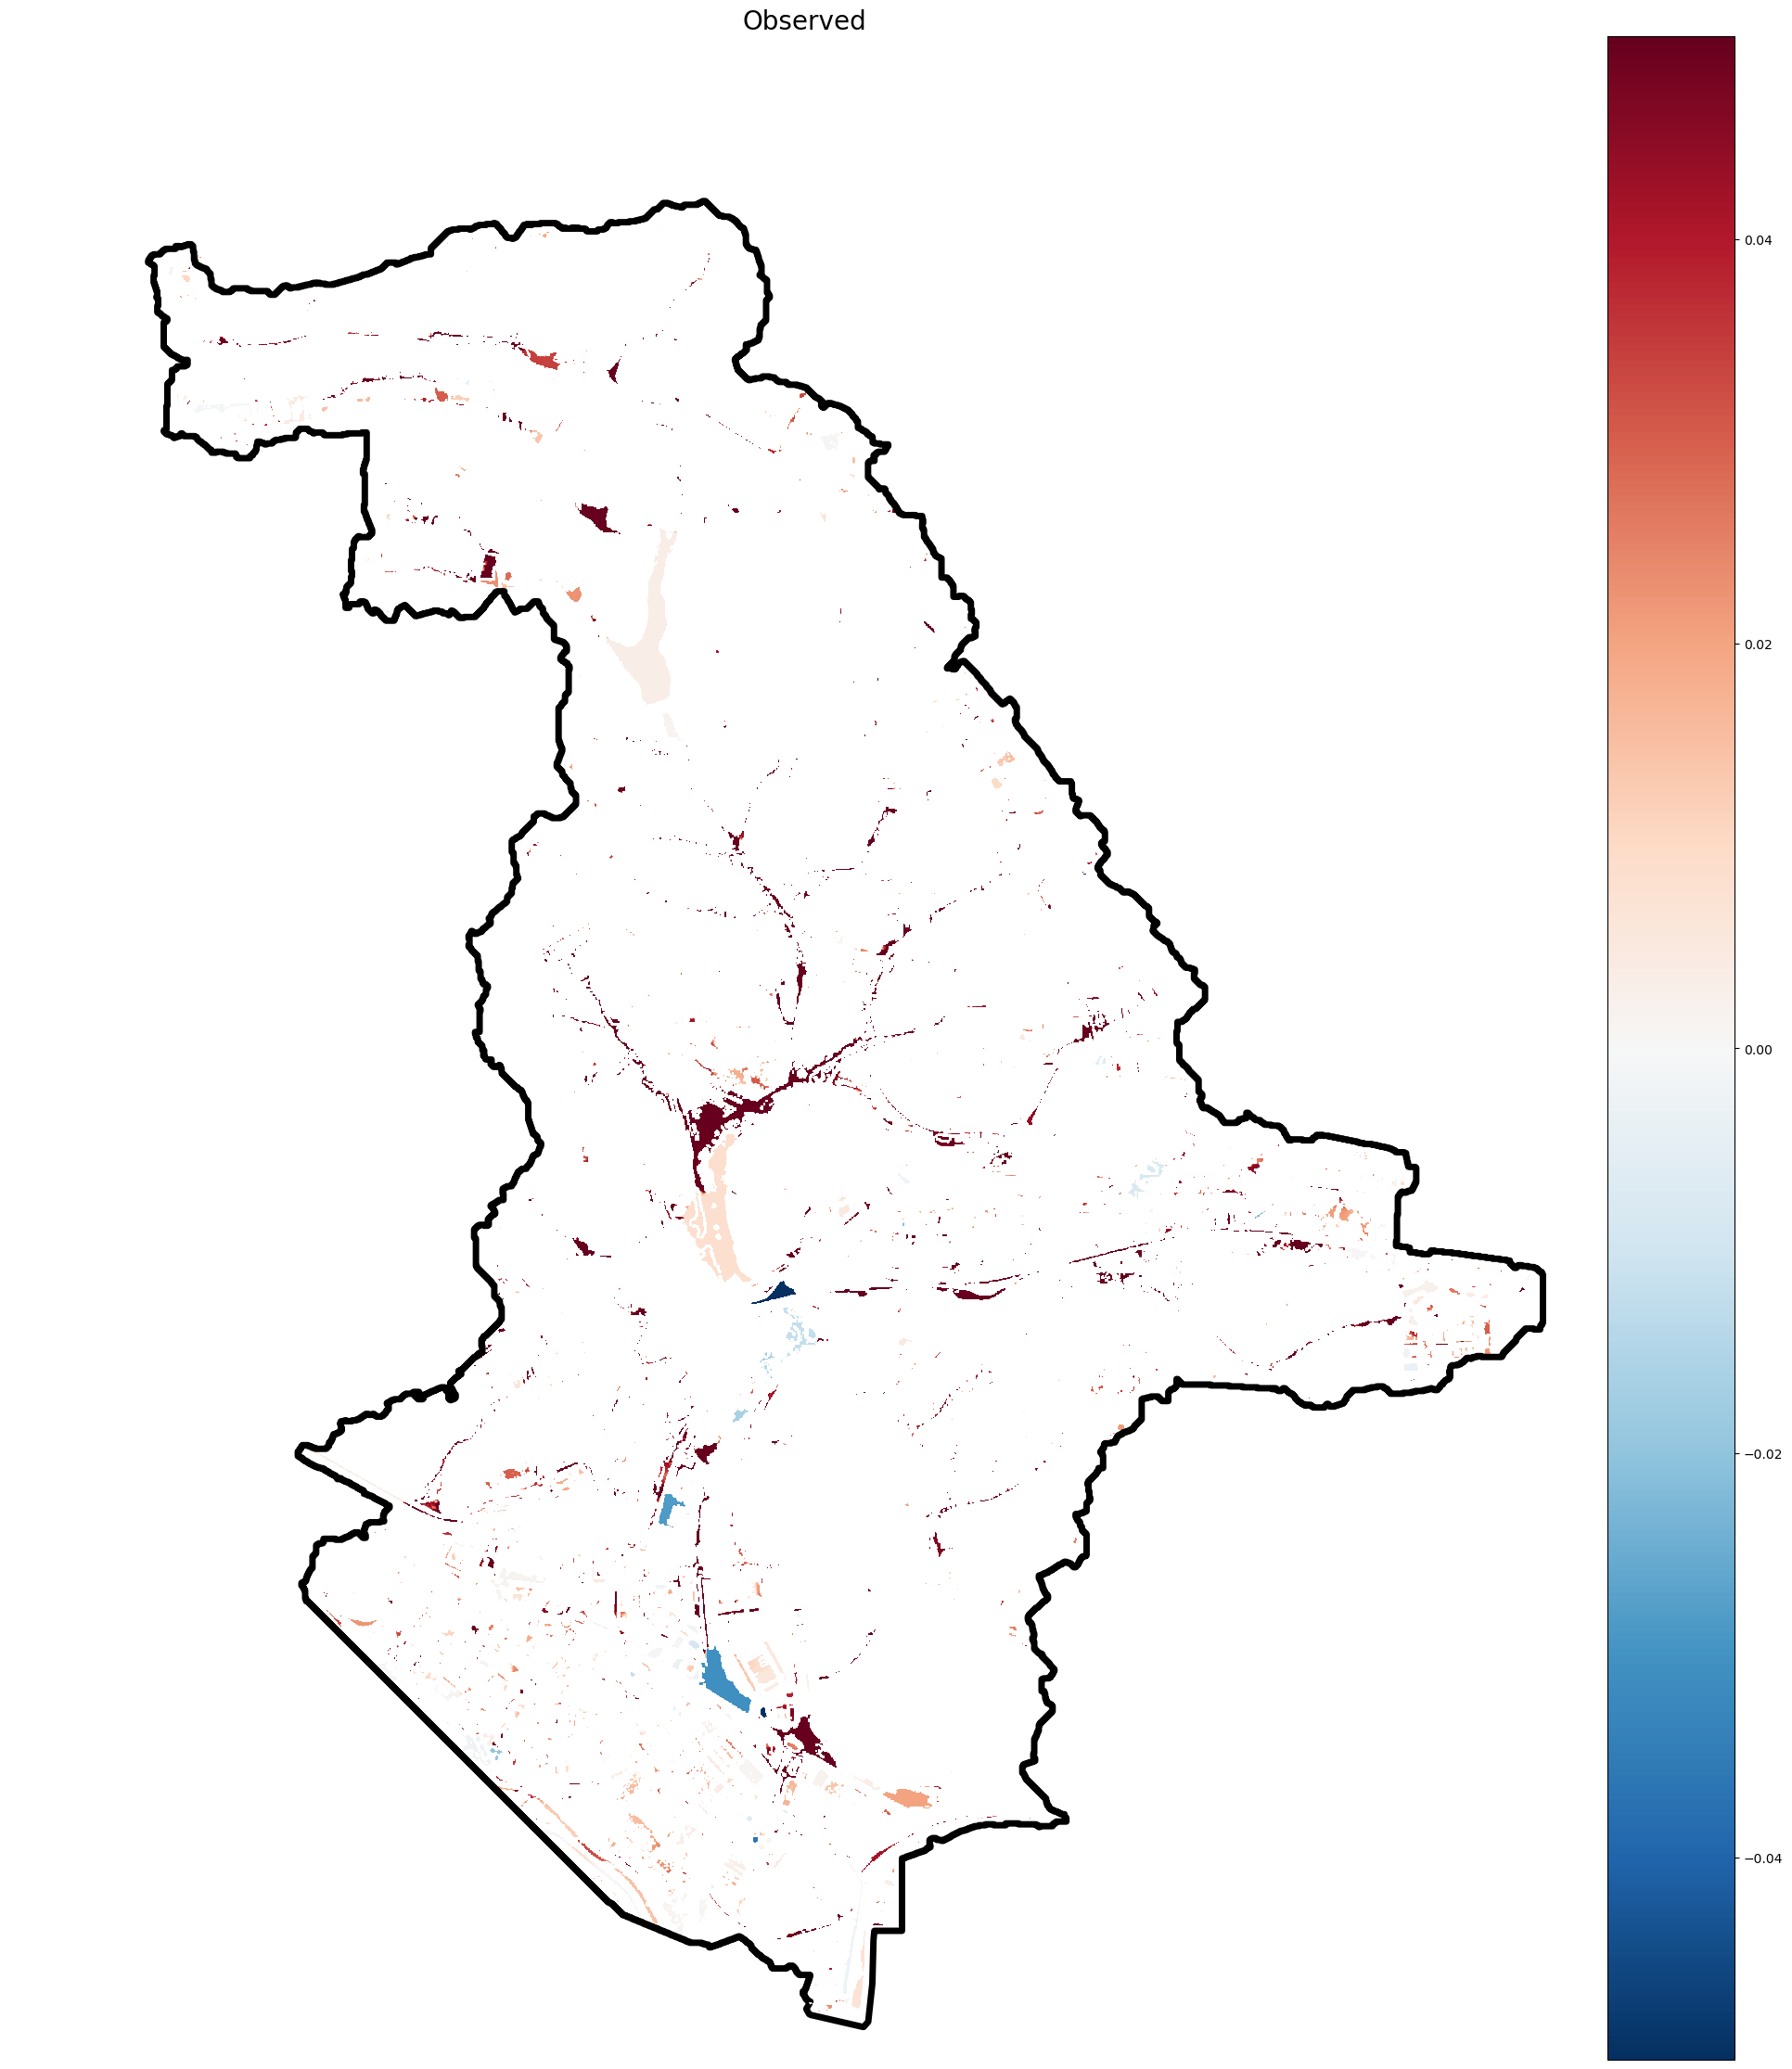

In [447]:
fig, axs = plt.subplots(ncols=1, figsize=(24, 40))
# plot_difference_between_extremes(wb_dict, 'Depth', 'Idealised', axs, False)
plot_difference_between_extremes(wb_dict, 'Depth', 'Observed', axs, False, True)

In [388]:
catchment_dict = wb_dict
variable_name = 'Depth'
method_name = 'Idealised'

# Find the catchment shapefile
model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
catchment_gdf = gpd.read_file(catchment_shp)

# Get string relating to most/least extreme scenarios
if method_name == 'Idealised':
    most_extreme_str,least_extreme_str = '6h_sp_bl_0.9',"6h_sp_fl_0.1"
elif method_name == 'Observed':
    most_extreme_str,least_extreme_str = '6h_c5',"6h_c8"        
elif method_name == 'SinglePeak_Scaled':
    most_extreme_str,least_extreme_str = '6h_sp_+0%', "6h_sp_+20%"      

most_extreme = prep_for_folium_plotting(model_directory+ f"{most_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif")
least_extreme = prep_for_folium_plotting(model_directory+ f"{least_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif")

most_extreme.data[np.isnan(most_extreme.data) & (~np.isnan(least_extreme.data))] = 0
least_extreme.data[np.isnan(least_extreme.data) & (~np.isnan(most_extreme.data))] = 0

# # Find the difference and save
diff= most_extreme -least_extreme

diff

In [396]:
model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(wb_dict['name'], 'Idealised')
fp = model_directory + f"CalculatedLayers/DifferencesBetweenExtremes_{'Depth'}_{'Idealised'}.tif"
array = rasterio.open(fp)
array = np.ma.masked_array(array[0], array[0] < 0.001)
# array = np.ma.masked_array(array, np.nan(array))

TypeError: 'DatasetReader' object is not subscriptable

In [382]:
# most_extreme = prep_for_folium_plotting(model_directory+ f"{most_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif")
# least_extreme = prep_for_folium_plotting(model_directory+ f"{least_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif")

In [362]:
test=np.array([[5,5,3,2], [1,1,1,1], [np.nan, np.nan,np.nan,np.nan], [5,5,3,2]])
test2=np.array([[4,4,3,2], [np.nan,1,1,np.nan], [np.nan, np.nan,np.nan,np.nan], [5,5,3,1]])
test-test2

array([[ 1.,  1.,  0.,  0.],
       [nan,  0.,  0., nan],
       [nan, nan, nan, nan],
       [ 0.,  0.,  0.,  1.]])

In [366]:
# if there is an NaN in this dataset, but in the other dataset it's not an NaN
test[np.isnan(test) & (~np.isnan(test2))] = 0
# If it's an nan in this dataset, 
test2[np.isnan(test2) & (~np.isnan(test))] = 0

test-test2

array([[ 1.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  1.],
       [nan, nan, nan, nan],
       [ 0.,  0.,  0.,  1.]])

In [353]:
# if there is an NaN in this dataset, but in the other dataset it's not an NaN
most_extreme.data[np.isnan(most_extreme.data) & (~np.isnan(least_extreme.data))] = 0
# If it's an nan in this dataset, 
least_extreme.data[np.isnan(least_extreme.data) & (~np.isnan(most_extreme.data))] = 0

# Find the difference and save
diff= most_extreme -least_extreme
diff

<xarray.DataArray (y: 4256, x: 5670)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 -1.546 -1.546 -1.546 ... -1.414 -1.414 -1.414
  * y            (y) float64 53.86 53.86 53.86 53.86 ... 53.76 53.76 53.76 53.76
    band         int64 1
    spatial_ref  int64 0

### Set values which are NaN to 0

In [346]:
most_extreme = prep_for_folium_plotting(model_directory+ f"{most_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif")
most_extreme.data[np.isnan(most_extreme.data)] = 0

In [347]:
np.unique(np.isnan(most_extreme.data),return_counts=True)

(array([False]), array([24131520]))

### Set values which are NaN in this array, but not NaN in the other array to 0

In [350]:
most_extreme = prep_for_folium_plotting(model_directory+ f"{most_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif")
most_extreme.data[np.isnan(most_extreme.data) & (~np.isnan(least_extreme.data))] = 0
# most_extreme.data[(~np.isnan(least_extreme.data) & np.isnan(most_extreme.data)).all()] = 0

In [351]:
np.unique(np.isnan(most_extreme.data),return_counts=True)

(array([False,  True]), array([ 1454552, 22676968]))

In [ ]:
import pylab
pylab.hist(most_extreme.data[~np.isnan(most_extreme.data)],bins=20);

In [319]:
# most_extreme.data[np.where(np.isnan(most_extreme).data & (~np.isnan(least_extreme).data))] ==0
# most_extreme.data[np.where(np.isnan(most_extreme.data))] ==0
most_extreme = prep_for_folium_plotting(model_directory+ f"{most_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif")
most_extreme.data[np.isnan(most_extreme.data)] = 0
most_extreme.data

# np.where((np.isnan(most_extreme.data)) & (np.isnan(least_extreme.data)))
# np.where(np.isnan(most_extreme.data)) and np.where(~np.isnan(least_extreme.data))

# most_extreme.data = np.where((np.isnan(most_extreme.data)) & (~np.isnan(least_extreme.data), 0, np.nan))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
find_difference_between_extremes(wb_dict, 'Depth', 'Idealised')
find_difference_between_extremes(wb_dict, 'Depth', 'Observed')

In [416]:
fp

'../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles/CalculatedLayers/DifferencesBetweenExtremes_Depth_Idealised.tif'

In [ ]:
def plot_spatial(axs,fp, catchment_gdf,  cbar=True, colors=None, labels=None,legend=True):
    
    #################################################################
    # Read in and prepare data
    #################################################################
    # Read in shapefile for use in cropping
    with rasterio.open(fp) as raster_crs:
        # Get crs to read in the catchment shape file
        crop_raster_profile = raster_crs.profile
        crop_bound_utm13N = catchment_gdf.to_crs(crop_raster_profile["crs"])    
    
    # Read in raster data amd crop to the shapefile
    with rasterio.open(fp) as src:
        single_cropped_image, single_cropped_meta = es.crop_image(
        src, crop_bound_utm13N)
    
    # Create the extent object for plotting
    single_crop_extent = plotting_extent(single_cropped_image[0], single_cropped_meta["transform"])
    
    #################################################################
    # Set up colors for plotting
    #################################################################
    # For landcover plot (where colours list is specified)
    if colors!=None:
        # Create the colourmap
        cmap = mpl.colors.ListedColormap(colors)
        # And set up the legend object
        if legend == True:
            patches_list = []
            for i, color in  enumerate(colors):
                patch =  mpatches.Patch(color=color, label=labels[i])
                patches_list.append(patch)  
            axs.legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =5);
    
    # For terrain plot
    else:
        cmap = 'RdBu_r'
    
    #################################################################
    # Mask array if necessary (in this case this is for the terrain data)
    #################################################################
    # For landcover plot
    if colors != None:
        # Mask array (don't want to include values of 0, as these are no data values here)
        single_cropped_image = np.ma.masked_array(single_cropped_image[0], single_cropped_image[0] < 0.001)
        # Define a vmin and vmax (so it uses the values for this plot)
        vmin = np.nanmin(single_cropped_image)
        vmax = np.nanmax(single_cropped_image)
    
    # For terrain plot
    # Define a vmin and vmax (so it's consistent across the plots)
    else:
        vmin = -0.05
        vmax = 0.05
#         vmin = np.nanmin(single_cropped_image)
#         vmax = np.nanmax(single_cropped_image)
    
    #################################################################
    # Plot the image
    #################################################################
    crop_bound_utm13N.boundary.plot(ax=axs, color="black", zorder=10)
    ep.plot_bands(single_cropped_image, ax=axs, extent=single_crop_extent, cmap = cmap, 
                      vmin=vmin,vmax=vmax,cbar=cbar)
        
    # Add the watercourse track
    watercourses_clip.plot(ax=axs, linewidth=3, color = 'black')    
    axs.axis('off')

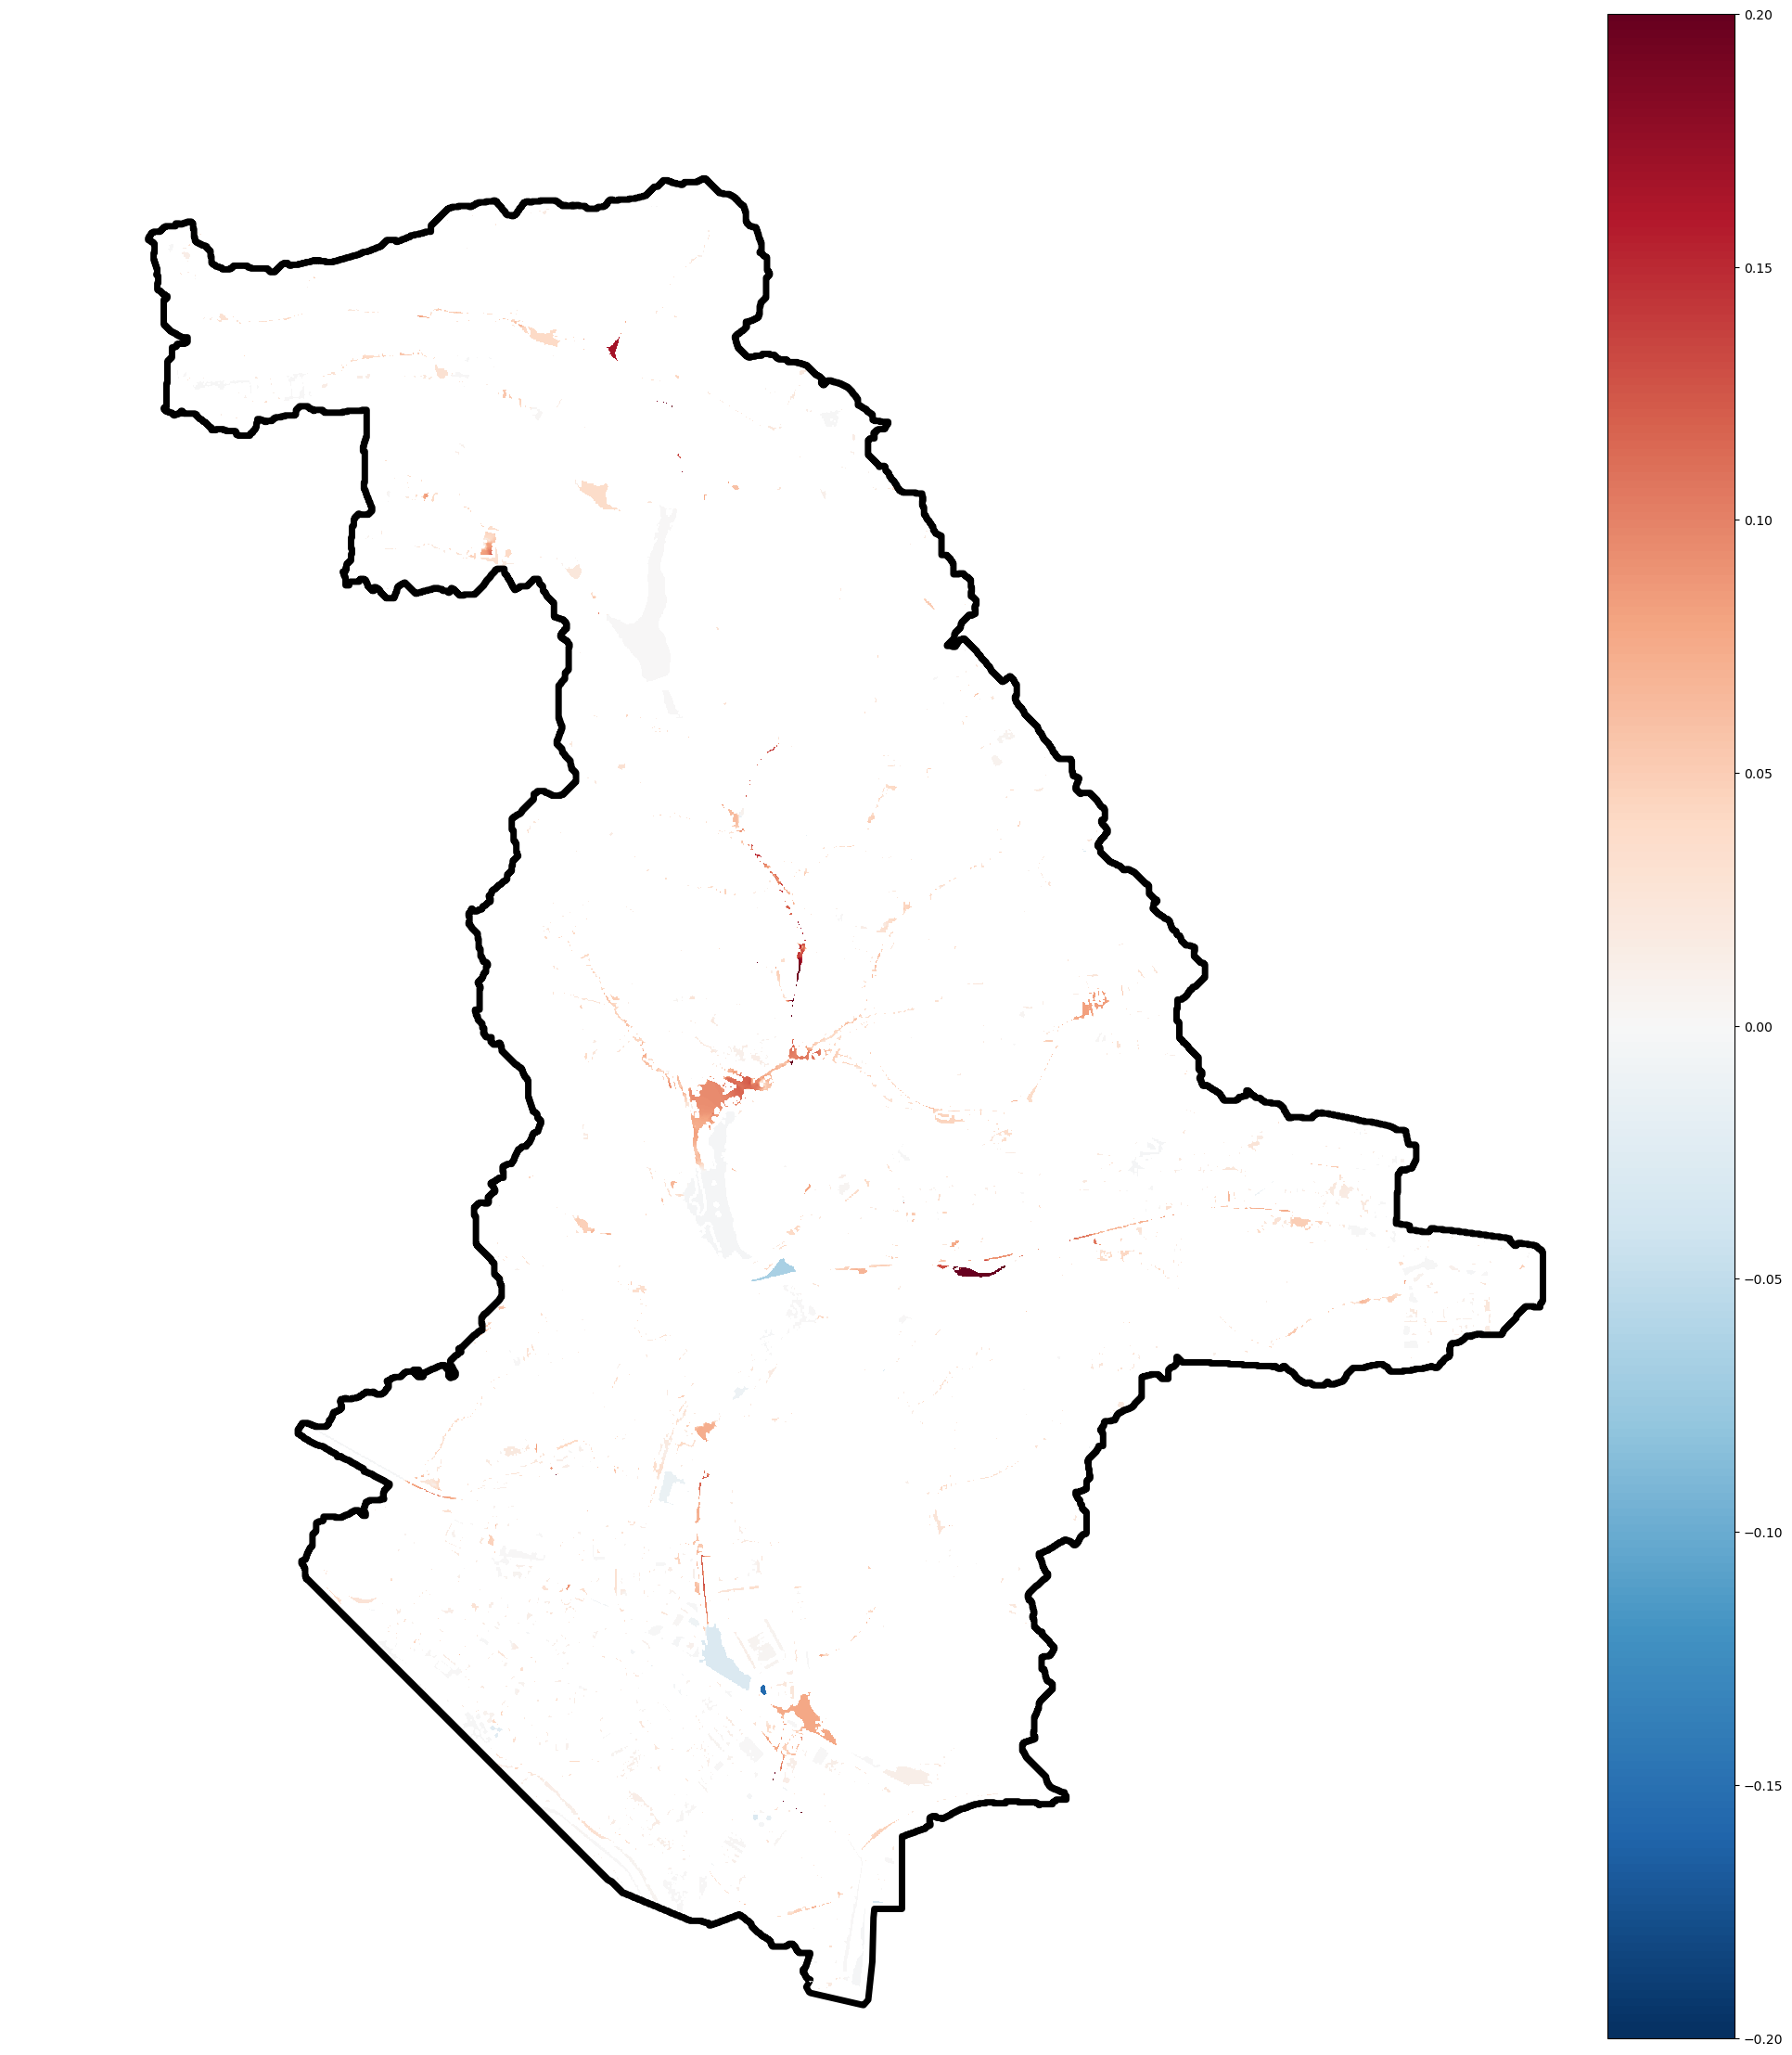

In [439]:
fig, ax = plt.subplots(figsize=(24, 40))
# Find the catchment shapefile
model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
catchment_gdf = gpd.read_file(catchment_shp)
add_basemap=False
#######################################
#######################################
# Make the plot
#######################################
#######################################
# Plot catchment boundary
catchment_gdf.plot(ax=ax, facecolor="none", linewidth=5, edgecolor = 'black')
# Add openstreetmap basemap
if add_basemap == True:
    cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)

# Plot data
fp = model_directory + f"CalculatedLayers/DifferencesBetweenExtremes_{variable_name}_{method_name}.tif"
array = rasterio.open(fp)
#array = np.ma.masked_array(array, array == 0)

cmap = mpl.cm.RdBu_r.copy()
# cmap.set_bad('w', 1.)
# image = plot.show(array, ax=ax,  cmap=cmap,  vmin=np.nanmin(band1),  vmax=np.nanmax(band1)-1)
image = plot.show(array, ax=ax,  cmap=cmap,  vmin=-0.2,  vmax=0.2)

# image = plot.show(array, ax=ax,  cmap=cmap,  vmin=-0.05,  vmax=0.05)

if add_basemap == True:
    im = image.get_images()[1]
else:
    im = image.get_images()[0]

# Add colorbar
divider = make_axes_locatable(ax)
add_colorbar= True
if add_colorbar == True:  
    cax = divider.append_axes("right", size="8%", pad=0.09)
    fig.colorbar(im, cax)

ax.axis('off');
# # Title
# ax.set_title(method_name, fontsize =20);

In [154]:
find_difference_between_extremes(wb_dict, 'Depth', 'Idealised')
find_difference_between_extremes(wb_dict, 'Depth', 'Observed')

../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles/CalculatedLayers/DifferencesBetweenExtremes_Depth_Idealised.tif
../../../FloodModelling/WykeBeckModels/Model_ObservedProfiles/CalculatedLayers/DifferencesBetweenExtremes_Depth_Observed.tif


### Create versions of both scenarios where any flooded cell (>0.1m) has a value of 1, and the rest have 0

In [7]:
# most_extreme_binary = most_extreme.copy()
# most_extreme_binary.values[(most_extreme_binary.values >=0.1)] = 1
# most_extreme_binary.values[(most_extreme_binary.values <0.1)] = 0
# most_extreme_binary.values[np.isnan(most_extreme_binary.values)] = 0

# least_extreme_binary = least_extreme.copy()
# least_extreme_binary.values[(least_extreme_binary.values >=0.1)] = 1
# least_extreme_binary.values[(least_extreme_binary.values <0.1)] = 0
# least_extreme_binary.values[np.isnan(least_extreme_binary.values)] = 0

### Find the difference: 
i.e. cells have a value of:  
-1 if FL01 is bigger than BL09 (darkred)  
0 if there is no difference (either flooded in both scenarios or neither)  
1 if BL09 is bigger than FL01 (darkolivegreen)  

In [8]:
# diff_binary = most_extreme_binary -least_extreme_binary
# np.unique(diff_binary)

### Change the 0 values to np.nan (so they don't have a colour on the map)

In [9]:
# least_extreme_binary.values[(least_extreme_binary.values ==0)] = np.nan
# most_extreme_binary.values[(most_extreme_binary.values ==0)] = np.nan
# diff_binary.values[(diff_binary.values ==0)] = np.nan

### Find the difference in values

### Convert this into a measure of whether the difference is positive or negative
0 = diff <0 (LEAST EXTREME bigger than MOST EXTREME) Red  
1 = diff == 0 (LEAST EXTREME==MOST EXTREME) Grey  
2 = diff >0 (MOST EXTREME bigger than LEAST EXTREME) Green  

In [71]:
pos_neg_depth_diff = np.where((np.isnan(diff)), np.nan, 
                          np.where((diff < 0), 0,
                            np.where((diff == 0), 1,
                                np.where((diff > 0), 2, 500))))
save_array_as_raster(pos_neg_depth_diff, model_directory + "CalculatedLayers/PosNegDifferencesBetweenExtremes.tif", out_meta) 

In [76]:
from matplotlib import cm
import branca.colormap as cm
colormap = cm.LinearColormap(colors=["red","violet","blue"], index=[np.nanmin(most_extreme),np.nanmax(most_extreme)],
                             vmin=np.nanmin(most_extreme),vmax=np.nanmax(most_extreme))

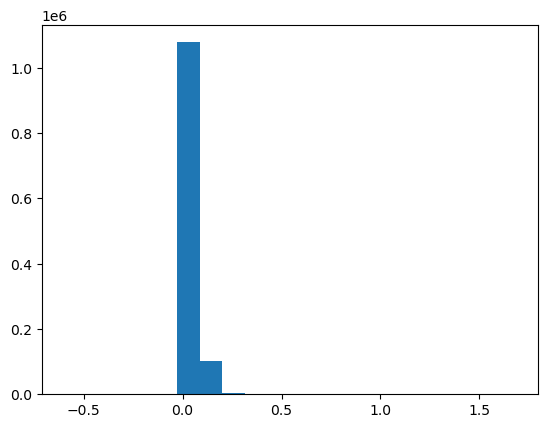

In [156]:
# pylab.hist(diff.data[~np.isnan(diff.data)],bins=20);

### Plot of difference in depth between most extreme scenarios
Green is where the back loaded profile has deeper flooding than the front loaded profile.  
Red is where the front loaded profile has deeper flooding than the back loaded profile.

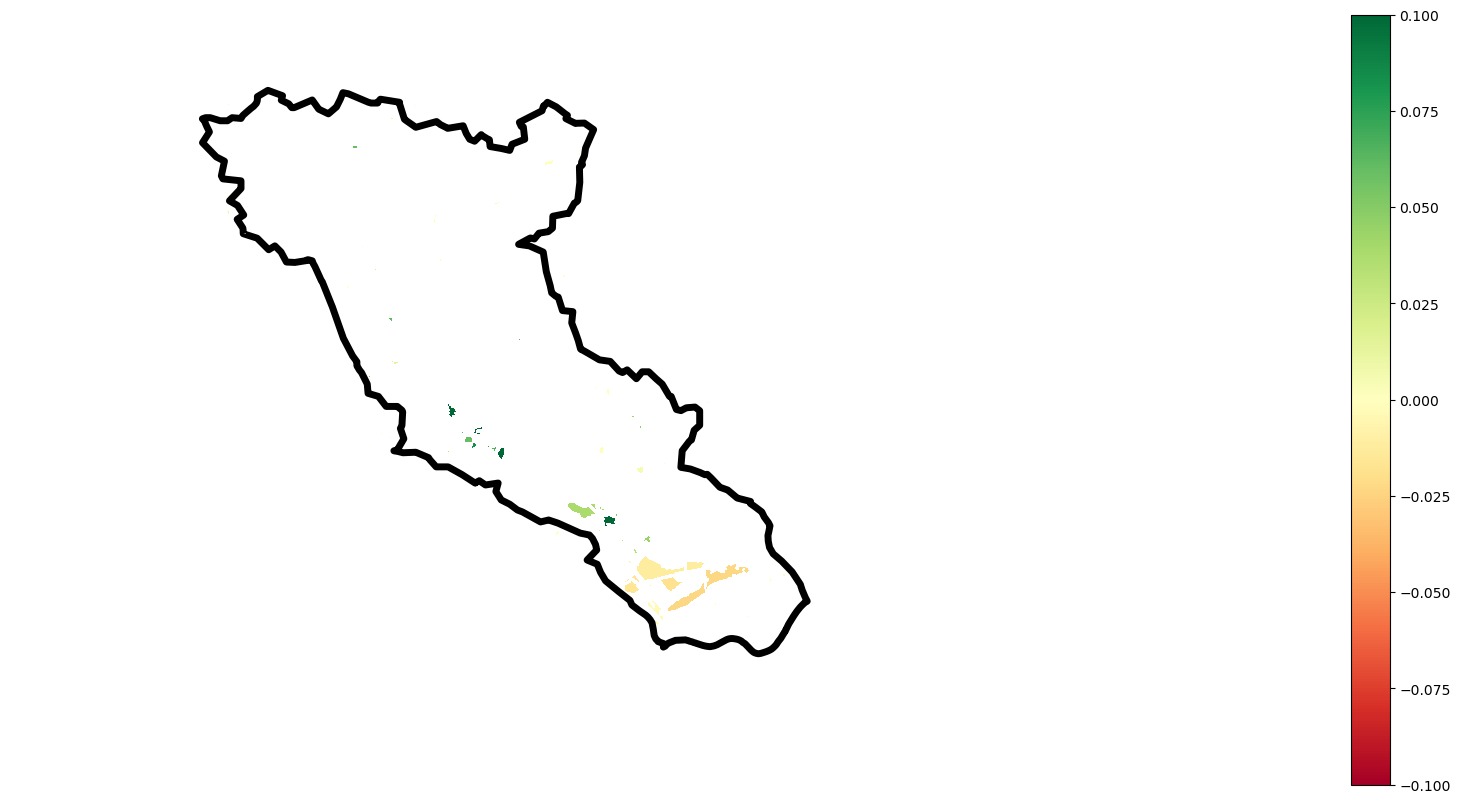

In [169]:
add_basemap =  False
fig, ax = plt.subplots(figsize=(24, 10))
# Plot catchment boundary
catchment_gdf.plot(ax=ax, facecolor="none", linewidth=5, edgecolor = 'black')
# Add openstreetmap basemap
if add_basemap == True:
    cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
# Plot data
fp = model_directory + "CalculatedLayers/DifferencesBetweenExtremes.tif"
array = rasterio.open(fp)
# plot.show(array, ax= axs, cmap=orig_cmap, vmin = np.nanmin(array), np.nanmax(array))
image = plot.show(array, ax=ax,  cmap='RdYlGn',  vmin=-0.1,  vmax=0.1)
if add_basemap == True:
    im = image.get_images()[1]
else:
    im = image.get_images()[0]
fig.colorbar(im, ax=ax, pad=0.1)
ax.axis('off');

### Create colourmaps

In [72]:
# # Create discrete cmap
colors_list = [ "red", "grey", "green"]
cmap_posneg = mpl.colors.ListedColormap(colors_list)
import branca.colormap as cm
cmap_min=round(np.nanmin(diff.data),1)
cmap_max=round(np.nanmax(diff.data),1)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red","violet","blue"])
colormap = cm.LinearColormap(colors=["red","violet","blue"], index=[np.nanmin(most_extreme),np.nanmax(most_extreme)],
                             vmin=np.nanmin(most_extreme),vmax=np.nanmax(most_extreme))

# from branca.colormap import linear
# x=linear.YlOrRd_09.scale(cmap_min,cmap_max)
# x

# # colors_list_tinary = [ "darkred", "darkolivegreen"]
# # cmap_tinary = mpl.colors.ListedColormap(colors_list_tinary)

# colors_list_binary =  [ "red","green"]
# cmap_binary = mpl.colors.ListedColormap(colors_list_binary)

### Plot

In [39]:
# data  = ma.masked_invalid(diff)
# plt.hist(data.data[np.isfinite(data.data)])
from matplotlib import cm
# # import branca.colormap as cm
# cmap = cm.LinearColormap(cm.magma_r.colors,vmin=0.3, vmax=1)
# cmap_func = lambda x: ImageColor.getcolor(cmap(x), 'RGBA') if ~np.isnan(x) else (0,0,0,0)


In [40]:
# Set up figure
f = folium.Figure(width=1000, height=1000)

# Create base map - location figures were from clat, clon, but wanted to create map before loop
mapa = folium.Map(location=centre_location,zoom_start=13).add_to(f)
folium.TileLayer(tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
    attr="No Base Map",name="No Base Map",show=True).add_to(mapa)

# Catchment boundary
catchment_boundary_feature_group = FeatureGroup(name=catchment_name)
catchment_boundary_feature_group.add_child(folium.GeoJson(data=catchment_gdf["geometry"], style_function=lambda x, 
                                     fillColor='#00000000', color='Black': { "fillColor": '#00000000',"color": 'Black',}))
mapa.add_child(catchment_boundary_feature_group)

###########################################
# Get coordinates needed in plotting
clat, clon = most_extreme.y.values.mean(), most_extreme.x.values.mean()
mlat, mlon = most_extreme.y.values.min(), most_extreme.x.values.min()
xlat, xlon = most_extreme.y.values.max(), most_extreme.x.values.max()
###########################################

# Pos Neg depth difference
###########################################
data  = ma.masked_invalid(pos_neg_depth_diff)
colored_data = colorize(data.data, cmap = cmap_posneg)
feature_group1 = FeatureGroup(name='PosNegDepthDiff')
feature_group1.add_child(folium.raster_layers.ImageOverlay(colored_data,[[mlat, mlon], [xlat, xlon]],
                          opacity=0.8,interactive=True, popup='Test'))
mapa.add_child(feature_group1)

# Actual values
###########################################
data  = ma.masked_invalid(least_extreme)
colored_data = colorize(data.data, cmap = colormap)
feature_group2 = FeatureGroup(name='MostExtreme')
feature_group2.add_child(folium.raster_layers.ImageOverlay(colored_data,[[mlat, mlon], [xlat, xlon]],
                          opacity=0.8,interactive=True, popup='Test'))
mapa.add_child(feature_group2)

data  = ma.masked_invalid(most_extreme)
colored_data = colorize(data.data, cmap = colormap)
feature_group3 = FeatureGroup(name='LeastExtreme')
feature_group3.add_child(folium.raster_layers.ImageOverlay(colored_data,[[mlat, mlon], [xlat, xlon]],
                          opacity=0.8,interactive=True, popup='Test'))
mapa.add_child(feature_group3)

###########################################
# Mask out nans
# data  = ma.masked_invalid(diff)
# colored_data = colorize(data.data, cmap = cmap)
# feature_group5 = FeatureGroup(name='Difference (actual)')
# feature_group5.add_child(folium.raster_layers.ImageOverlay(colored_data,[[mlat, mlon], [xlat, xlon]],
#                           opacity=0.8,interactive=True, popup='Difference (actual)'))
# mapa.add_child(feature_group5)

# Add layers to map
mapa.add_child(LayerControl("topright", collapsed = False))
display(mapa)

ValueError: <branca.colormap.LinearColormap object at 0x7f76c9183880> is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

### Read in landcover data

In [ ]:
# landcover_binary_fp =  model_directory +"LandCover_clipped_reclassified.tif"
# landcover_full_fp =  model_directory +"LandCover_clipped.tif"

### Read in flood data

In [ ]:
# fp_feh= '../../../../FloodModelling/MeganModel_New/6h_feh_sp/{} (Max).Resampled.Terrain.tif'
# fp_sp_10 = '../../../../FloodModelling/MeganModel_New/6h_sp_+10/{} (Max).Resampled.Terrain.tif'
# fp_b2 = '../../../../FloodModelling/MeganModel_New/6h_sp_bl_0.9/{} (Max).Resampled.Terrain.tif'
# fp_f2= '../../../../FloodModelling/MeganModel_New/6h_sp_fl_0.1/{} (Max).Resampled.Terrain.tif'
# fp_f1= '../../../../FloodModelling/MeganModel_New/6h_sp_fl_0.3/{} (Max).Resampled.Terrain.tif'

# depth_b2, out_meta = prepare_rainfall_scenario_raster(fp_b2.format('Depth'), remove_little_values)
# depth_feh = prepare_rainfall_scenario_raster(fp_feh.format('Depth'), remove_little_values)[0]
# depth_sp_10 = prepare_rainfall_scenario_raster(fp_sp_10.format('Depth'), remove_little_values)[0]
# depth_f2 = prepare_rainfall_scenario_raster(fp_f2.format('Depth'), remove_little_values)[0]
# depth_f1 = prepare_rainfall_scenario_raster(fp_f1.format('Depth'), remove_little_values)[0]

### Set all values over 0.1 to 1, and rest to 0

In [ ]:
# depth_feh = np.where(depth_feh>=0.1, 1, 0)
# depth_sp_10= np.where(depth_sp_10>=0.1, 1, 0)
# depth_b2 = np.where(depth_b2 >=0.1, 1, 0)
# depth_f2 = np.where(depth_f2>=0.1, 1, 0)
# depth_f1 = np.where(depth_f1 >=0.1, 1, 0)

### Find difference between the FEH and another profile (ones which are off the 1:1 line on scatter plot).

In [ ]:
# diff_feh_b2 = depth_b2 - depth_feh 
# diff_f1_b2 = depth_b2 - depth_f1 

### Set 0s to np.nan ()

In [ ]:
# depth_feh = np.where(depth_feh==0, np.nan, depth_feh)
# depth_sp_10 = np.where(depth_sp_10==0, np.nan, depth_sp_10)
# depth_b2 = np.where(depth_b2==0, np.nan, depth_b2)
# depth_f1 = np.where(depth_f1==0, np.nan, depth_f1)

### Test whether processing has worked as expected

In [ ]:
# def colorize(array, cmap):
#     cm = plt.cm.get_cmap(cmap)    
#     if np.nanmin(array) == np.nanmax(array):
#         return np.uint8(cm(array)  * 255)
#     else:
#         normed_data = (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array)) 
#         return np.uint8(cm(normed_data)  * 255)


In [ ]:
# np.nanmax(diff[np.isfinite(diff)])
# np.histogram(depth_f1[np.isfinite(depth_f1)])
# np.unique(depth_f1)

### Where difference is 0, set to np.nan

In [ ]:
# # Difference in scatter plot
# diff_feh_b2 = np.where(diff_feh_b2==0, np.nan, diff_feh_b2)
# # No difference in scatter plot
# diff_f1_b2 = np.where(diff_f1_b2==0, np.nan, diff_f1_b2)

### Define colourmaps

In [ ]:
# cmap_landcover_binary = mpl.colors.ListedColormap(['grey', 'white'])
# cmap_diff = mpl.colors.ListedColormap(['purple', 'darkorange', 'green'])
# cmap = mpl.colors.ListedColormap(['white', 'blue'])
# cmap_landcover_full = mpl.colors.ListedColormap(['darkslategrey', 'khaki', 'darkgreen','darkturquoise','#59F74D', 'slateblue', 'lightgreen', 'palegreen', 'pink'])

### Save rasters (needed for plotting)

In [ ]:
# # save_array_as_raster(diff_feh_b2, '../../../../FloodModelling/MeganModel_New/diff_feh_b2.tif', out_meta) 
# # save_array_as_raster(diff_f1_b2, '../../../../FloodModelling/MeganModel_New/diff_f1_b2.tif', out_meta) 

# save_array_as_raster(depth_sp_10, '../../../../FloodModelling/MeganModel_New/depth_sp_10_test.tif', out_meta) 
# save_array_as_raster(depth_feh, '../../../../FloodModelling/MeganModel_New/depth_feh_test.tif', out_meta) 
# save_array_as_raster(depth_b2, '../../../../FloodModelling/MeganModel_New/depth_b2_test.tif', out_meta) 
# save_array_as_raster(depth_f1, '../../../../FloodModelling/MeganModel_New/depth_f1_test.tif', out_meta) 

### Set up for plotting

In [ ]:
# # dict_of_fps_and_names = {'landcover_full': landcover_full_fp,
# #                         'landcover_binary': landcover_binary_fp,
# #                         "diff_f1_b2": '../../../../FloodModelling/MeganModel_New/diff_f1_b2.tif',
# #                          "diff_feh_b2": '../../../../FloodModelling/MeganModel_New/diff_feh_b2.tif',
# #                          "b2": '../../../../FloodModelling/MeganModel_New/depth_b2_test.tif',
# #                          "f1":'../../../../FloodModelling/MeganModel_New/depth_f1_test.tif',
# #                         "feh":'../../../../FloodModelling/MeganModel_New/depth_feh_test.tif'}    


# dict_of_fps_and_names = {'landcover_binary': landcover_binary_fp,
#                          "sp10":"../../../../FloodModelling/MeganModel_New/depth_sp_10_test.tif",
#                         "feh":"../../../../FloodModelling/MeganModel_New/depth_feh_test.tif"}    


# dict_of_cmaps ={'landcover_binary': cmap_landcover_binary, "sp10":cmap, 'landcover_full': cmap_landcover_full, "diff_feh_b2":cmap_diff,
#                 "diff_f1_b2":cmap_diff,"b2":cmap, "feh":cmap , "f1":cmap }

### Plot with folium

In [ ]:
# # Set up figure
# f = folium.Figure(width=800, height=700)

# # Create base map - location figures were from clat, clon, but wanted to create map before loop
# mapa = folium.Map(location=[53.768306874761016, -1.3756056884868098],zoom_start=13).add_to(f)
# folium.TileLayer(
#     opacity=1,
#     tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
#     attr="No Base Map",
#     name="No Base Map",
#     show=True
# ).add_to(mapa)

# # Add to map
# catchment_boundary_feature_group = FeatureGroup(name='Catchment boundary')
# catchment_boundary_feature_group.add_child(folium.GeoJson(data=catchment_gdf["geometry"], style_function=lambda x, 
#                                                           fillColor='#00000000', color='Black': {
#         "fillColor": '#00000000',"color": 'Black',}))

# # Add raster data
# for name,fp in dict_of_fps_and_names.items():
    
#     # read in with xarray and convert projection
#     xarray_dataarray = prep_for_folium_plotting(fp)
#     # Get coordinates needed in plotting
#     clat, clon = xarray_dataarray.y.values.mean(), xarray_dataarray.x.values.mean()
#     mlat, mlon = xarray_dataarray.y.values.min(), xarray_dataarray.x.values.min()
#     xlat, xlon = xarray_dataarray.y.values.max(), xarray_dataarray.x.values.max()
#     # Apply colormap
#     data  = ma.masked_invalid(xarray_dataarray.values)
#     colored_data = colorize(data.data, cmap=dict_of_cmaps[name])
#     # Add to map
#     feature_group1 = FeatureGroup(name=name)
#     feature_group1.add_child(folium.raster_layers.ImageOverlay(colored_data,
#                               [[mlat, mlon], [xlat, xlon]],
#                               opacity=1,interactive=True, popup=name))
#     mapa.add_child(feature_group1)

# # Add legend
# macro = MacroElement()
# macro._template = Template(template)
# mapa.get_root().add_child(macro)

# # Add layer control button
# mapa.add_child(catchment_boundary_feature_group)
# mapa.add_child(LayerControl("topright", collapsed = False))
# display(mapa)    

In [ ]:
template = """
{% macro html(this, kwargs) %}
<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">
  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            left: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});
  </script>
</head>
<body>
 
<div id='maplegend' class='maplegend' 
    style='position: fixed; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 20px; bottom: 20px;'>
<div class='legend-title'> Key </div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#800080.;opacity:1;'></span> B2 flooded (not FEH)</li>
    <li><span style='background:#008000;opacity:1;'></span> FEH flooded (not B2)</li>
  </ul>
</div>
</div>
 
</body>
</html>
<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""